In [1]:
import scanpy as sc
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt

In [2]:
adata = sc.read_h5ad('LUAD2_umap.h5ad')

In [3]:
adata2 = adata[:, adata.var["highly_variable"]].copy()
sc.pp.scale(adata2, max_value=10)

In [4]:
adata2

AnnData object with n_obs × n_vars = 89887 × 2000
    obs: 'SampleID', 'Batch', 'Tissue', 'Cells', 'PatientID', 'Gender', 'Disease', 'Stage', 'Age', 'T', 'N', 'M', 'CellName', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'CellName_colors', 'hvg', 'log1p'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
import pandas as pd

cell_names = adata2.obs["CellName"]
cell_names_cat = pd.Categorical(cell_names)
cell_names_encoded = cell_names_cat.codes
adata2.obs["CellName_encoded"] = cell_names_encoded
print(adata2.obs["CellName_encoded"])
categories = cell_names_cat.categories
encoding_to_category = dict(enumerate(categories))
print(encoding_to_category)

2018jz1_AAACCTGAGTCCAGGA-1     3
2018jz1_AAACCTGAGTGCAAGC-1    13
2018jz1_AAACCTGGTCATTAGC-1    15
2018jz1_AAACCTGGTTCGAATC-1    13
2018jz1_AAACGGGAGAAACGCC-1    13
                              ..
BT1432_TTTGGTTCATTCTCAT-1     15
BT1432_TTTGTCACACATGTGT-1      3
BT1432_TTTGTCAGTCTACCTC-1     14
BT1432_TTTGTCATCACGCATA-1     14
BT1432_TTTGTCATCGCGGATC-1      1
Name: CellName_encoded, Length: 89887, dtype: int8
整数编码对应的类别：
Index(['ATII', 'B', 'Basal', 'CD4', 'CD8', 'Cilia', 'Club', 'DC', 'EC', 'Epi',
       'Fib', 'Gran', 'Mast', 'Mo', 'NE', 'NK', 'Tregs'],
      dtype='object')
整数编码到类别的映射：
{0: 'ATII', 1: 'B', 2: 'Basal', 3: 'CD4', 4: 'CD8', 5: 'Cilia', 6: 'Club', 7: 'DC', 8: 'EC', 9: 'Epi', 10: 'Fib', 11: 'Gran', 12: 'Mast', 13: 'Mo', 14: 'NE', 15: 'NK', 16: 'Tregs'}


In [6]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt
from py_monocle import (
    learn_graph,
    order_cells,
    compute_cell_states,
    regression_analysis,
    differential_expression_genes,
)
adata2.X = sparse.csr_matrix(adata2.X)
barcodes = adata2.obs_names.to_numpy() 
features = adata2.var_names.to_numpy() 
data = adata2.X.data  
indices = adata2.X.indices  
indptr = adata2.X.indptr  


umap = adata2.obsm["X_umap"] 
#louvain = adata2.obs["louvain"].to_numpy(dtype=int)  # Louvain 
#leiden = adata2.obs["leiden"].to_numpy(dtype=int)  # Louvain
CellName = adata2.obs["CellName_encoded"].to_numpy(dtype=int)
expression_matrix = sparse.csr_matrix(
    (data, indices, indptr),
    shape=(len(barcodes), len(features))
)
projected_points, mst, centroids = learn_graph(matrix=umap, clusters=CellName)#louvain leiden CellName

In [7]:
fontsize = 16
plt.rcParams.update({
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize
})

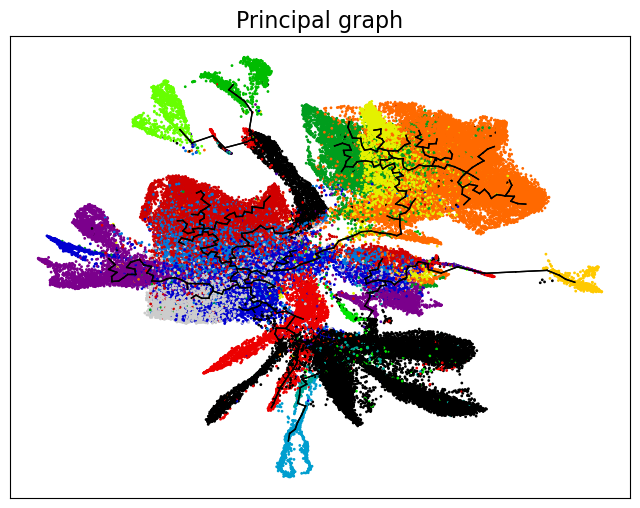

In [8]:
plt.figure(1, (8, 6))
plt.title("Principal graph")
plt.scatter(umap[:, 0], umap[:, 1], c=CellName, s=1, cmap="nipy_spectral")

edges = np.array(mst.nonzero()).T
for edge in edges:
    plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.xticks([])
plt.yticks([])
plt.show()

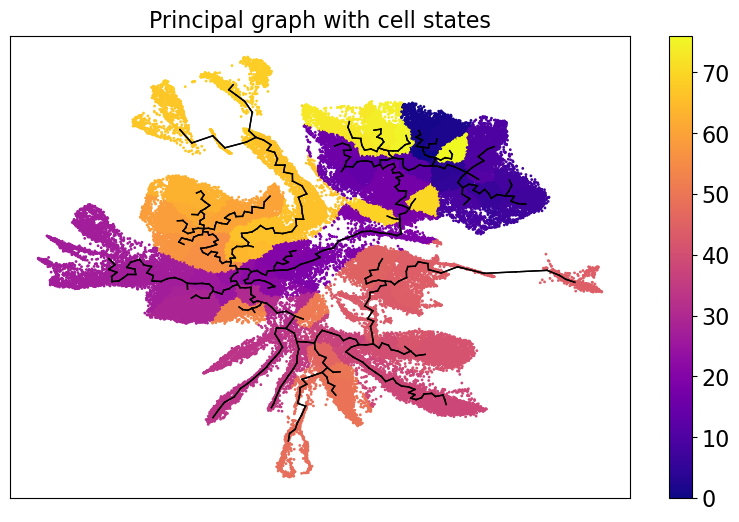

In [9]:
plt.figure(1, (10, 6))
plt.title("Principal graph with cell states")
cell_states, _ = compute_cell_states(umap, centroids, mst)
plt.scatter(umap[:, 0], umap[:, 1], c=cell_states, s=1, cmap="plasma") #nipy_spectral
plt.colorbar()
edges = np.array(mst.nonzero()).T
for edge in edges:
    plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
encoding_to_category

{0: 'ATII',
 1: 'B',
 2: 'Basal',
 3: 'CD4',
 4: 'CD8',
 5: 'Cilia',
 6: 'Club',
 7: 'DC',
 8: 'EC',
 9: 'Epi',
 10: 'Fib',
 11: 'Gran',
 12: 'Mast',
 13: 'Mo',
 14: 'NE',
 15: 'NK',
 16: 'Tregs'}

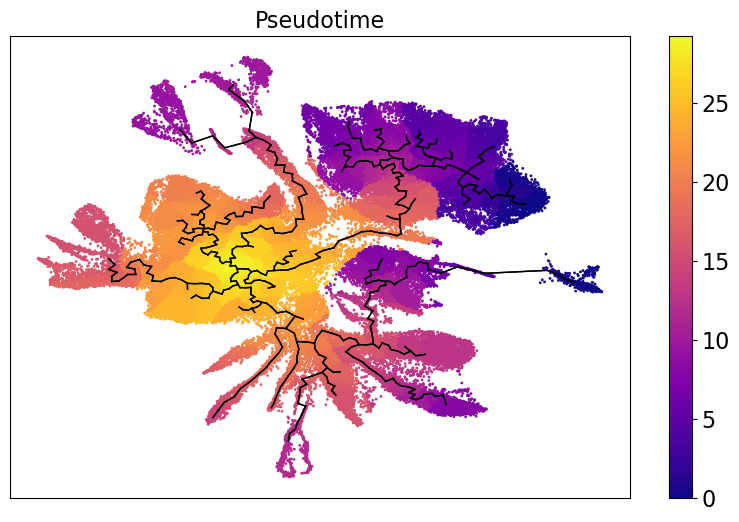

In [11]:
pseudotime = order_cells(
    umap, centroids,
    mst=mst,
    projected_points=projected_points,
    root_cells=13,
)
pseudotime = np.max(pseudotime)-pseudotime
plt.figure(1, (10, 6))
plt.title("Pseudotime")
plt.scatter(umap[:, 0], umap[:, 1], c=pseudotime, s=1, cmap="plasma")
#add edge
edges = np.array(mst.nonzero()).T
for edge in edges:
    plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.xticks([])
plt.yticks([])
plt.colorbar()
#plt.savefig('/data/yypdata/NMF/LUAD2/figures/LUADumap_monocle.png')
plt.show()

In [12]:
import palantir

adata3 = adata[adata.obs['CellName'].isin(['ATII','NE']),:]
sc.pp.highly_variable_genes(adata3, n_top_genes=1000)
sc.pp.pca(adata3)
dm_res = palantir.utils.run_diffusion_maps(adata3, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(adata3)
sc.pp.neighbors(adata3)
sc.tl.umap(adata3)

/home/yangyoupeng/anaconda3/envs/torch/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:700: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [13]:
fontsize = 18
plt.rcParams.update({
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize
})

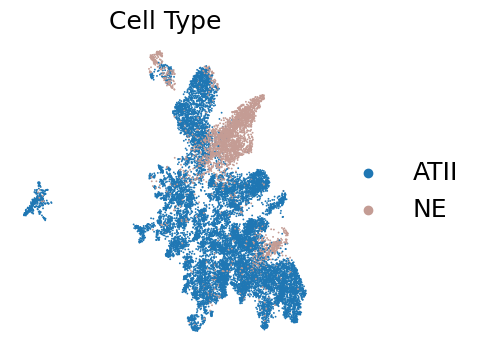

In [14]:
sc.pl.embedding(
    adata3,
    basis="umap",
    frameon=False,
    color = 'CellName',
    title='Cell Type',
    save = 'ATII_NE_umap2.png'
)

In [15]:
imputed_X = palantir.utils.run_magic_imputation(adata3)

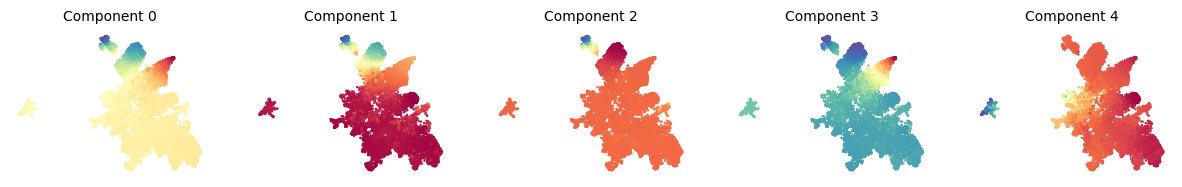

In [16]:
palantir.plot.plot_diffusion_components(adata3)
plt.show()

In [17]:
terminal_states = pd.Series(
    ["ATII-NE", "ATII-1", "ATII-2"],
    index=["BT1297_AGAGTGGCATACGCTA-1", "BT1292_GTAGTCACATTAGCCA-1", "BT1430_CCTCAGTCATCCGCGA-1"],
)
start_cell = "2018jz1_AAGTCTGGTAGCGTGA-1"
pr_res = palantir.core.run_palantir(
    adata3, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.015165869394938152 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.6134681781133016 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [18]:
fontsize = 18
plt.rcParams.update({
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize
})

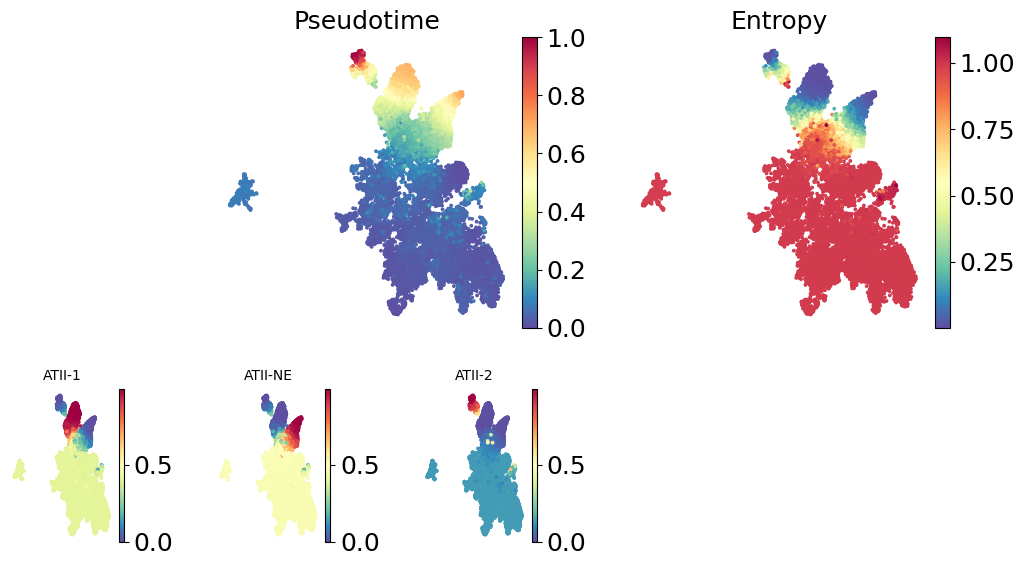

In [19]:
palantir.plot.plot_palantir_results(adata3, s=3)
#plt.savefig('/data/yypdata/NMF/LUAD2/figures/palantir_results_atiine.png')
plt.show()

In [20]:
masks = palantir.presults.select_branch_cells(adata3, q=.01, eps=.01)

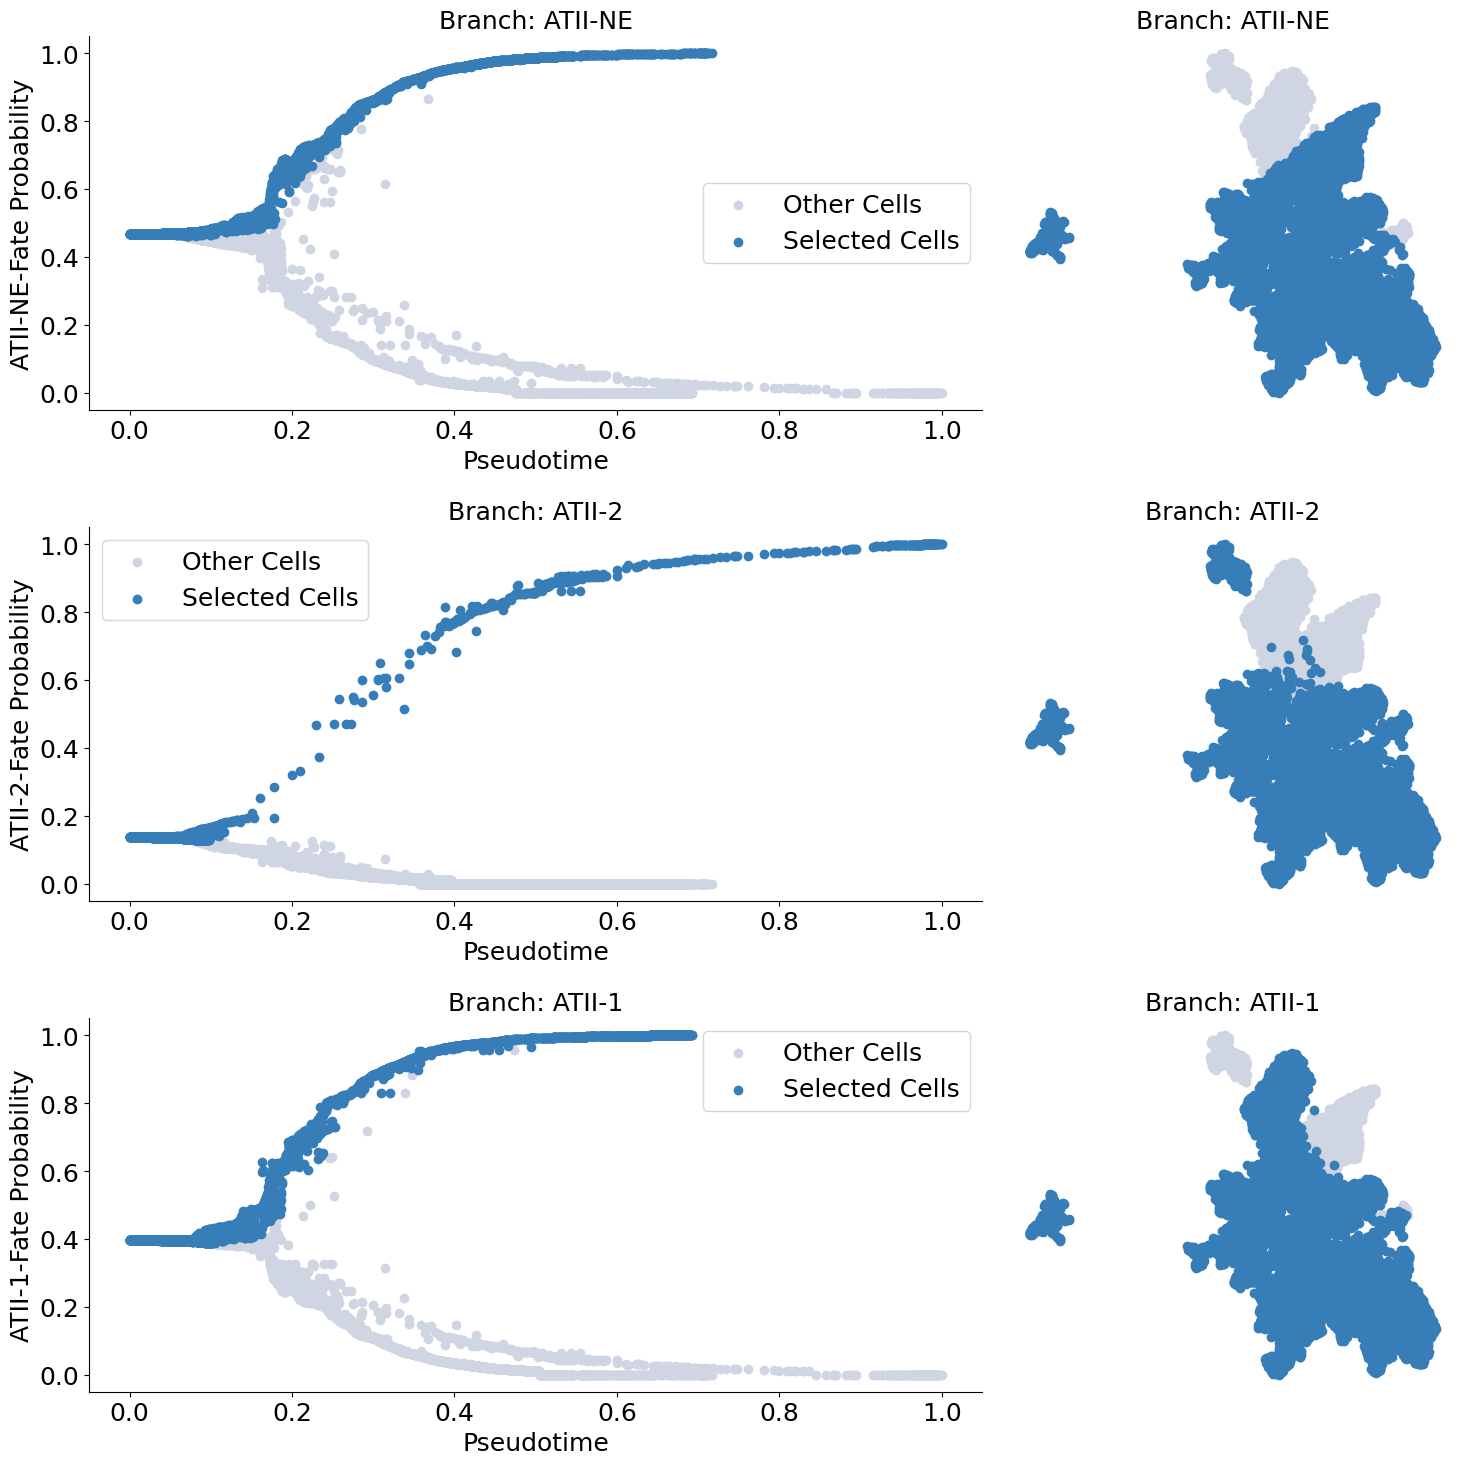

In [21]:
palantir.plot.plot_branch_selection(adata3)
plt.savefig('/data/yypdata/NMF/LUAD2/figures/branch_selection_atiine.png')
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[2025-05-09 09:36:21,955] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (14,585) and rank = 1.0.
[2025-05-09 09:36:21,955] [INFO    ] Using covariance function Matern52(ls=1.6735702514648438).
[2025-05-09 09:36:21,985] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2025-05-09 09:36:23,247] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: ATII-NE'}>

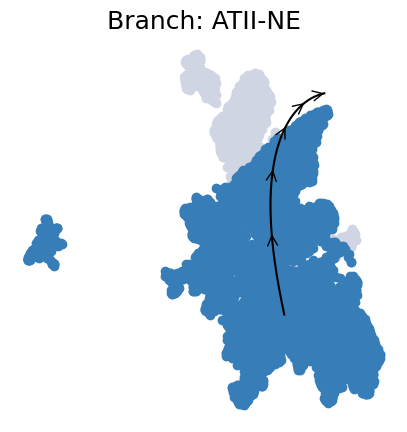

In [22]:
palantir.plot.plot_trajectory(adata3, "ATII-NE")#"BT1297_AGAGTGGCATACGCTA-1" BT1297_GGGCATCAGCGATTCT

[2025-05-09 09:39:12,674] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (14,585) and rank = 1.0.
[2025-05-09 09:39:12,675] [INFO    ] Using covariance function Matern52(ls=1.6735702514648438).
[2025-05-09 09:39:12,677] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2025-05-09 09:39:12,825] [INFO    ] Sigma interpreted as element-wise standard deviation.


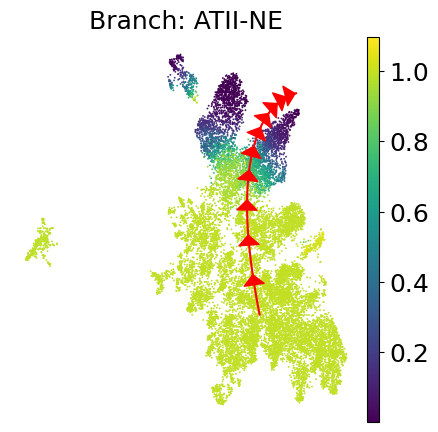

In [25]:
palantir.plot.plot_trajectory(
    adata3,
    "ATII-NE",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.4,head_width=.4"),
)
plt.savefig('/data/yypdata/NMF/LUAD2/figures/branch_NE_atiine.png')

In [26]:
gene_trends = palantir.presults.compute_gene_trends(
    adata3,
    expression_key="MAGIC_imputed_data",
)

ATII-1
[2025-05-09 09:39:32,956] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (14,712) and rank = 1.0.
[2025-05-09 09:39:32,957] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-05-09 09:39:34,485] [INFO    ] Sigma interpreted as element-wise standard deviation.
ATII-NE
[2025-05-09 09:39:37,955] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (14,585) and rank = 1.0.
[2025-05-09 09:39:37,958] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-05-09 09:39:38,797] [INFO    ] Sigma interpreted as element-wise standard deviation.
ATII-2
[2025-05-09 09:39:42,049] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (12,743) and rank = 1.0.
[2025-05-09 09:39:42,050] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-05-09 09:39:42,905] [INFO    ] Sigma interpreted as element-wise standard deviation.


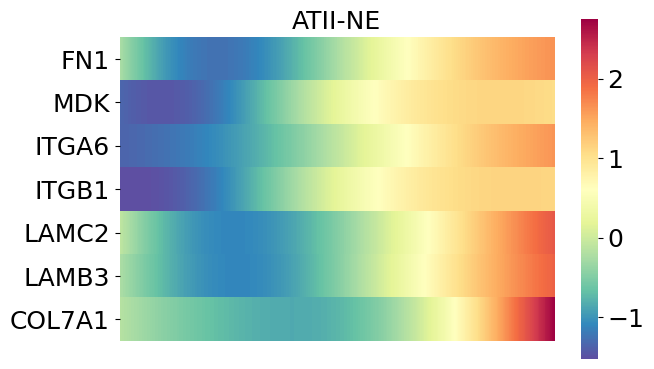

In [30]:
genes = ["FN1", "MDK", "ITGA6", "ITGB1",'LAMC2','LAMB3','COL7A1']
"""
palantir.plot.plot_gene_trend_heatmaps(adata3, genes,branch_names=['ATII-NE'])
plt.savefig('/data/yypdata/NMF/LUAD2/figures/gene_trend_heatmaps_atiine.png')
plt.show()
"""
fig = palantir.plot.plot_gene_trend_heatmaps(adata3, genes,branch_names=['ATII-NE'])
for ax in fig.axes:
    ax.title.set_fontsize(18)
plt.savefig('/data/yypdata/NMF/LUAD2/figures/gene_trend_heatmaps_atiine.png')